# SSNE Miniproject 5
### 318703 Tomasz Owienko
### 318718 Anna Schäfer
### Grupa piątek

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import MulticlassConfusionMatrix
import io
from PIL import Image
import torchvision
from pytorch_lightning.loggers import TensorBoardLogger


In [2]:
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

In [3]:
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

In [4]:
VALIDATION_PERCENTAGE = 0.10
batch_size = 32
TRAIN_PATH = "data/train.pkl"
TEST_PATH = "data/test_no_target.pkl"

In [5]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [6]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence


def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx = [x.clone().detach().unsqueeze(-1) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=-1)
    return (
        xx_pad,
        torch.tensor(yy, dtype=torch.long),
        torch.tensor(x_lens, dtype=torch.int).cpu(),
    )

In [7]:
with open(TRAIN_PATH, "rb") as f:
    train = pickle.load(f)

train_data = [[torch.from_numpy(t[0].astype(int)).float(), int(t[1])] for t in train]

<Axes: ylabel='Count'>

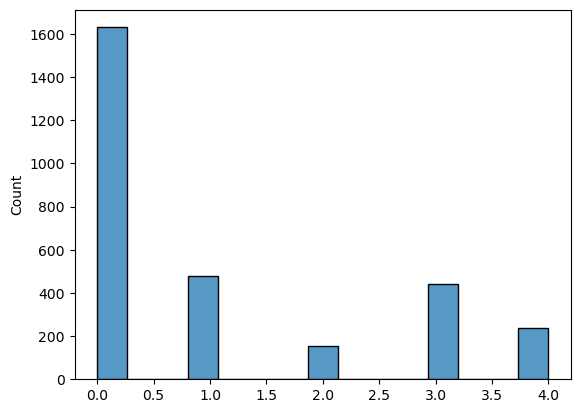

In [8]:
sns.histplot([label for _, label in train_data])

In [9]:
n_classes = len({label for _, label in train_data})
print(f"{n_classes} classes")
class_hist = torch.histogram(torch.Tensor([label for _, label in train_data]), bins=n_classes, density=True)
print(class_hist)

5 classes
torch.return_types.histogram(
hist=tensor([0.6933, 0.2033, 0.0655, 0.1876, 0.1004]),
bin_edges=tensor([0.0000, 0.8000, 1.6000, 2.4000, 3.2000, 4.0000]))


In [10]:
dataset_length = len(train_data)
val_size = int(dataset_length * VALIDATION_PERCENTAGE)
train_size = dataset_length - val_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

train_dataset = VariableLenDataset(
    [x[0] for x in train_subset], [x[1] for x in train_subset]
)
val_dataset = VariableLenDataset([x[0] for x in val_subset], [x[1] for x in val_subset])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad_collate,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad_collate,
    pin_memory=True,
)

In [11]:
_train_loader = DataLoader(
    train_subset, batch_size=32, shuffle=True, collate_fn=pad_collate
)
next(iter(_train_loader))[0].shape

torch.Size([32, 2515, 1])

In [12]:
class LSTMClassifier(pl.LightningModule):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, class_weights=None
    ):
        super(LSTMClassifier, self).__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm.flatten_parameters()
        self.fc = nn.Linear(hidden_size * num_layers * 2, output_size)
        self.dropout = nn.Dropout(0.4)
        
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        self.val_acc = MulticlassAccuracy(output_size)
        self.train_acc = MulticlassAccuracy(output_size)
        self.val_acc_per_class = MulticlassAccuracy(output_size, average="none")
        self.val_f1 = MulticlassF1Score(output_size)
            
        self.n_classes = output_size

    def forward(self, x, x_lens):
        x_packed = pack_padded_sequence(
            x, x_lens, batch_first=True, enforce_sorted=False
        )
        out, (hn, cn) = self.lstm(x_packed)
        cat = torch.cat((hn, cn), dim=2)
        cat = torch.transpose(cat, 0,1)
        cat = torch.flatten(cat, start_dim=1)
        x = self.fc(self.dropout(cat))
        return x

    def training_step(self, batch, batch_idx):
        x, y, x_lens = batch
        outputs = self(x, x_lens.cpu())
        loss = self.criterion(outputs, y)
        preds = outputs.argmax(dim=1)
        acc = self.val_acc(preds, y)
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, x_lens = batch
        outputs = self(x, x_lens.cpu())
        loss = self.criterion(outputs, y)
        preds = outputs.argmax(dim=1)
        acc = self.val_acc(preds, y)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        
        acc_per_class = self.val_acc_per_class(outputs.argmax(dim=1), y)
        self.log(f'val_acc_{y[0]}', acc_per_class[int(y[0])], on_step=False, on_epoch=True)
        
        self._val_preds_labels.append((preds, y))  # to reuse iun confusion matrix computation
        return loss
    
    def on_validation_epoch_start(self) -> None:
        self._val_preds_labels = []
    
    def on_validation_epoch_end(self) -> None:
        preds = torch.cat([p for p, _ in self._val_preds_labels])
        labels = torch.cat([l for _, l in self._val_preds_labels])
        confusion = MulticlassConfusionMatrix(num_classes=self.n_classes, normalize='true').to(device)
        computed_confusion = confusion(preds, labels)
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.heatmap(computed_confusion.cpu().numpy(), annot=True, annot_kws={"size": 16}, ax=ax, fmt=".3f", cmap="Greens", vmin=0, vmax=1)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        plt.close()
        buf.seek(0)
        im = Image.open(buf);
        im = torchvision.transforms.ToTensor()(im)
        logger = self.logger
        assert isinstance(logger, TensorBoardLogger)
        logger.experiment.add_image("val_confusion_matrix", im, self.current_epoch)
        self.log('val_mean_acc_unweighted', np.diagonal(computed_confusion.cpu().numpy()).sum() / self.n_classes)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [13]:
input_size = train_data[0][0].shape[1] if len(train_data[0][0].shape) > 1 else 1
hidden_size = 256
output_size = len(set(x[1] for x in train_data))

model = LSTMClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=2, class_weights=1 - class_hist.hist)

best_val_acc_callback = ModelCheckpoint(
    monitor="val_acc",
    filename="checkpoint_best_acc-{epoch:03d}-{val_acc:.5f}",
    save_top_k=3,
    mode="min",
)

last_epoch_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="epoch",
    mode="max",
    filename="checkpoint_last-{epoch:03d}-{train_loss:.5f}",
)

trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[best_val_acc_callback, last_epoch_callback, RichProgressBar()],
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name              ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ lstm              │ LSTM               │  791 K │
│ 1 │ fc                │ Linear             │  5.1 K │
│ 2 │ dropout           │ Dropout            │      0 │
│ 3 │ criterion         │ CrossEntropyLoss   │      0 │
│ 4 │ val_acc           │ MulticlassAccuracy │      0 │
│ 5 │ train_acc         │ MulticlassAccuracy │      0 │
│ 6 │ val_acc_per_class │ MulticlassAccuracy │      0 │
│ 7 │ val_f1            │ MulticlassF1Score  │      0 │
└───┴───────────────────┴────────────────────┴────────┘

Trainable params: 796 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 796 K                                                                                                
Total estimated model params size (MB): 3

Output()

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/tomek/miniconda3/envs/ssne_p3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connecto
r.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on 
this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

In [ ]:
with open(TEST_PATH, "rb") as f:
    test_data = pickle.load(f)

test_data = [torch.from_numpy(t.astype(int)).float().unsqueeze(-1) for t in test_data]
test_dataset = VariableLenDataset(test_data, [0 for _ in test_data])
test_loader = DataLoader(
    test_dataset, batch_size=50, shuffle=False, collate_fn=pad_collate
)